## A simple 1D model


Taken from https://machinelearningmastery.com/how-to-develop-a-generative-adversarial-network-for-a-1-dimensional-function-from-scratch-in-keras/

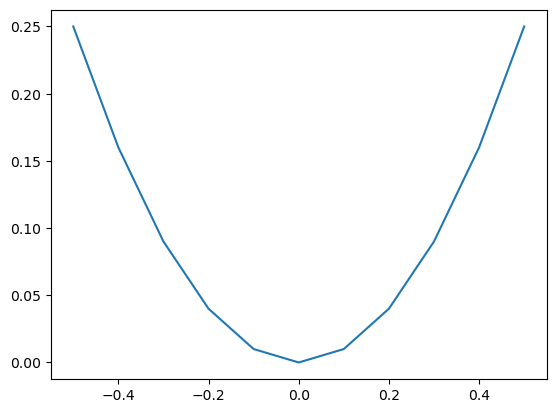

In [1]:
# demonstrate simple x^2 function
from matplotlib import pyplot
 
# simple function
def calculate(x):
 return x * x
 
# define inputs
inputs = [-0.5, -0.4, -0.3, -0.2, -0.1, 0, 0.1, 0.2, 0.3, 0.4, 0.5]
# calculate outputs
outputs = [calculate(x) for x in inputs]
# plot the result
pyplot.plot(inputs, outputs)
pyplot.show()

## Creating a distribution

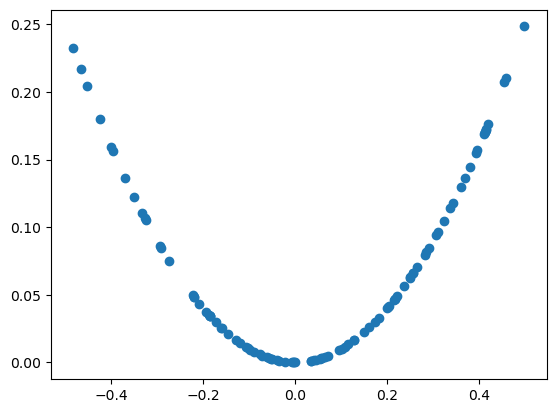

In [2]:
# example of generating random samples from X^2
from numpy.random import rand
from numpy import hstack
from matplotlib import pyplot
 
# generate randoms sample from x^2
def generate_samples(n=100):
    # generate random inputs in [-0.5, 0.5]
    X1 = rand(n) - 0.5
    # generate outputs X^2 (quadratic)
    X2 = X1 * X1
    # stack arrays
    X1 = X1.reshape(n, 1)
    X2 = X2.reshape(n, 1)
    return hstack((X1, X2))
 
# generate samples
data = generate_samples()
# plot samples
pyplot.scatter(data[:, 0], data[:, 1])
pyplot.show()

## Define the discriminator

2023-04-24 17:00:45.629334: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-04-24 17:00:45.702241: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-04-24 17:00:45.704168: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-04-24 17:00:45.708183: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 25)                75        
                                                                 
 dense_1 (Dense)             (None, 1)                 26        
                                                                 
Total params: 101
Trainable params: 101
Non-trainable params: 0
_________________________________________________________________


o
2023-04-24 17:00:45.712674: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-04-24 17:00:45.714542: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-04-24 17:00:46.828251: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-04-24 17:00:46.828646: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-04-24 17:00:46.829000: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from

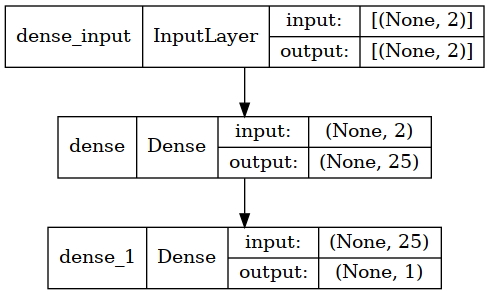

In [3]:
from keras.models import Sequential
from keras.layers import Dense
from keras.utils.vis_utils import plot_model
 
# define the standalone discriminator model
def define_discriminator(n_inputs=2):
    model = Sequential()
    model.add(Dense(25, activation='relu', kernel_initializer='he_uniform', input_dim=n_inputs))
    model.add(Dense(1, activation='sigmoid'))
    # compile model
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model
 
# define the discriminator model
model = define_discriminator()
# summarize the model
model.summary()
# plot the model
plot_model(model, to_file='discriminator_plot.png', show_shapes=True, show_layer_names=True)


First, we can update our generate_samples() function from the prediction section and call it generate_real_samples() and have it also return the output class labels for the real samples, specifically, an array of 1 values, where class=1 means real.

In [4]:
# generate n real samples with class labels
def generate_real_samples(n):
    # generate inputs in [-0.5, 0.5]
    X1 = rand(n) - 0.5
    # generate outputs X^2
    X2 = X1 * X1
    # stack arrays
    X1 = X1.reshape(n, 1)
    X2 = X2.reshape(n, 1)
    X = hstack((X1, X2))
    # generate class labels
    y = ones((n, 1))
    return X, y

In this case, we will generate random values in the range -1 and 1 for both elements of a sample. The output class label for all of these examples is 0.

This function will act as our fake generator model.

In [5]:
# generate n fake samples with class labels
def generate_fake_samples(n):
    # generate inputs in [-1, 1]
    X1 = -1 + rand(n) * 2
    # generate outputs in [-1, 1]
    X2 = -1 + rand(n) * 2
    # stack arrays
    X1 = X1.reshape(n, 1)
    X2 = X2.reshape(n, 1)
    X = hstack((X1, X2))
    # generate class labels
    y = zeros((n, 1))
    return X, y

Next, we need a function to train and evaluate the discriminator model.

This can be achieved by manually enumerating the training epochs and for each epoch generating a half batch of real examples and a half batch of fake examples, and updating the model on each, e.g. one whole batch of examples. The train() function could be used, but in this case, we will use the train_on_batch() function directly.

The model can then be evaluated on the generated examples and we can report the classification accuracy on the real and fake samples.

The train_discriminator() function below implements this, training the model for 1,000 batches and using 128 samples per batch (64 fake and 64 real).



In [6]:
# define and fit a discriminator model
from numpy import zeros
from numpy import ones
from numpy import hstack
from numpy.random import rand
from numpy.random import randn
from keras.models import Sequential
from keras.layers import Dense

# train the discriminator model
def train_discriminator(model, n_epochs=1000, n_batch=128):
    half_batch = int(n_batch / 2)
    # run epochs manually
    for i in range(n_epochs):
        # generate real examples
        X_real, y_real = generate_real_samples(half_batch)
        
        # update model
        model.train_on_batch(X_real, y_real)
        
        # generate fake examples
        X_fake, y_fake = generate_fake_samples(half_batch)
        
        # update model
        model.train_on_batch(X_fake, y_fake)

        # evaluate the model
        _, acc_real = model.evaluate(X_real, y_real, verbose=0)
        _, acc_fake = model.evaluate(X_fake, y_fake, verbose=0)
        print(i, acc_real, acc_fake)
    


In [7]:
# fit the model
train_discriminator(model)

0 0.265625 0.484375
1 0.265625 0.5625
2 0.21875 0.546875
3 0.234375 0.453125
4 0.359375 0.546875
5 0.21875 0.40625
6 0.140625 0.546875
7 0.328125 0.40625
8 0.1875 0.40625
9 0.15625 0.484375
10 0.09375 0.546875
11 0.09375 0.46875
12 0.078125 0.5
13 0.09375 0.5
14 0.0625 0.46875
15 0.03125 0.453125
16 0.046875 0.53125
17 0.046875 0.546875
18 0.015625 0.421875
19 0.015625 0.53125
20 0.09375 0.421875
21 0.015625 0.5625
22 0.0 0.4375
23 0.0 0.625
24 0.046875 0.5625
25 0.0 0.40625
26 0.0 0.5
27 0.046875 0.4375
28 0.0 0.578125
29 0.015625 0.5625
30 0.0 0.5
31 0.0 0.59375
32 0.03125 0.6875
33 0.0 0.640625
34 0.015625 0.546875
35 0.03125 0.65625
36 0.0 0.5
37 0.0 0.5
38 0.015625 0.578125
39 0.03125 0.453125
40 0.0 0.484375
41 0.015625 0.625
42 0.046875 0.484375
43 0.0 0.609375
44 0.0 0.609375
45 0.03125 0.515625
46 0.015625 0.578125
47 0.03125 0.6875
48 0.015625 0.65625
49 0.046875 0.65625
50 0.046875 0.578125
51 0.0 0.625
52 0.046875 0.578125
53 0.046875 0.6875
54 0.078125 0.46875
55 0.0625 0.

421 0.859375 0.859375
422 0.8125 0.890625
423 0.84375 0.921875
424 0.84375 0.921875
425 0.890625 0.890625
426 0.78125 0.96875
427 0.796875 0.96875
428 0.828125 0.875
429 0.828125 0.875
430 0.78125 0.921875
431 0.890625 0.953125
432 0.78125 0.90625
433 0.859375 0.953125
434 0.875 0.921875
435 0.90625 0.90625
436 0.859375 0.84375
437 0.828125 0.859375
438 0.859375 0.921875
439 0.859375 0.9375
440 0.796875 0.9375
441 0.84375 0.890625
442 0.78125 0.984375
443 0.890625 0.9375
444 0.8125 0.859375
445 0.8125 0.890625
446 0.859375 0.9375
447 0.828125 0.84375
448 0.78125 0.90625
449 0.90625 0.875
450 0.890625 0.90625
451 0.796875 0.890625
452 0.84375 0.921875
453 0.765625 0.84375
454 0.84375 0.90625
455 0.8125 0.90625
456 0.859375 0.875
457 0.859375 0.890625
458 0.90625 0.859375
459 0.859375 0.890625
460 0.8125 0.90625
461 0.859375 0.90625
462 0.921875 0.890625
463 0.84375 0.84375
464 0.921875 0.96875
465 0.921875 0.984375
466 0.953125 0.90625
467 0.890625 0.921875
468 0.859375 0.859375
469 0.8

890 1.0 0.828125
891 1.0 0.90625
892 1.0 0.859375
893 1.0 0.9375
894 1.0 0.859375
895 1.0 0.828125
896 1.0 0.8125
897 1.0 0.828125
898 1.0 0.890625
899 1.0 0.859375
900 1.0 0.828125
901 1.0 0.875
902 1.0 0.890625
903 1.0 0.890625
904 1.0 0.84375
905 1.0 0.84375
906 1.0 0.8125
907 1.0 0.78125
908 1.0 0.890625
909 1.0 0.84375
910 1.0 0.828125
911 1.0 0.890625
912 1.0 0.9375
913 1.0 0.828125
914 1.0 0.875
915 1.0 0.8125
916 1.0 0.921875
917 1.0 0.859375
918 1.0 0.921875
919 1.0 0.890625
920 1.0 0.859375
921 1.0 0.84375
922 1.0 0.84375
923 1.0 0.828125
924 1.0 0.828125
925 1.0 0.828125
926 1.0 0.921875
927 1.0 0.875
928 1.0 0.921875
929 1.0 0.875
930 1.0 0.84375
931 1.0 0.84375
932 1.0 0.890625
933 1.0 0.875
934 1.0 0.796875
935 1.0 0.890625
936 1.0 0.875
937 1.0 0.875
938 1.0 0.90625
939 1.0 0.859375
940 1.0 0.84375
941 1.0 0.84375
942 1.0 0.765625
943 1.0 0.90625
944 1.0 0.890625
945 1.0 0.875
946 1.0 0.796875
947 1.0 0.875
948 1.0 0.828125
949 1.0 0.765625
950 1.0 0.796875
951 1.0 0.859

Training the discriminator model is straightforward. The goal is to train a generator model, not a discriminator model, and that is where the complexity of GANs truly lies.

## Define a Generator Model

The next step is to define the generator model.

The generator model takes as input a point from the latent space and generates a new sample, e.g. a vector with both the input and output elements of our function, e.g. x and x^2.

A latent variable is a hidden or unobserved variable, and a latent space is a multi-dimensional vector space of these variables. We can define the size of the latent space for our problem and the shape or distribution of variables in the latent space.

This is because the latent space has no meaning until the generator model starts assigning meaning to points in the space as it learns. After training, points in the latent space will correspond to points in the output space, e.g. in the space of generated samples.

We will define a small latent space of five dimensions and use the standard approach in the GAN literature of using a Gaussian distribution for each variable in the latent space. We will generate new inputs by drawing random numbers from a standard Gaussian distribution, i.e. mean of zero and a standard deviation of one.

- Inputs: Point in latent space, e.g. a five-element vector of Gaussian random numbers.
- Outputs: Two-element vector representing a generated sample for our function (x and x^2).

The generator model will be small like the discriminator model.

It will have a single hidden layer with five nodes and will use the ReLU activation function and the He weight initialization. The output layer will have two nodes for the two elements in a generated vector and will use a linear activation function.

A linear activation function is used because we know we want the generator to output a vector of real values and the scale will be [-0.5, 0.5] for the first element and about [0.0, 0.25] for the second element.

The model is not compiled. The reason for this is that the generator model is not fit directly.

The define_generator() function below defines and returns the generator model.

The size of the latent dimension is parameterized in case we want to play with it later, and the output shape of the model is also parameterized, matching the function for defining the discriminator model.

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 15)                90        
                                                                 
 dense_3 (Dense)             (None, 2)                 32        
                                                                 
Total params: 122
Trainable params: 122
Non-trainable params: 0
_________________________________________________________________


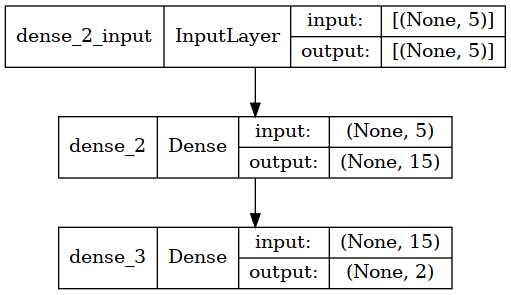

In [8]:
# define the generator model
from keras.models import Sequential
from keras.layers import Dense
from keras.utils.vis_utils import plot_model

# define the standalone generator model
def define_generator(latent_dim, n_outputs=2):
    model = Sequential()
    model.add(Dense(15, activation='relu', kernel_initializer='he_uniform', input_dim=latent_dim))
    model.add(Dense(n_outputs, activation='linear'))
    return model

# define the discriminator model
model = define_generator(5)
# summarize the model
model.summary()
# plot the model
plot_model(model, to_file='generator_plot.png', show_shapes=True, show_layer_names=True)


We can see that the model takes as input a random five-element vector from the latent space and outputs a two-element vector for our one-dimensional function.

This model cannot do much at the moment. Nevertheless, we can demonstrate how to use it to generate samples. This is not needed, but again, some of these elements may be useful later.

The first step is to generate new points in the latent space. We can achieve this by calling the randn() NumPy function for generating arrays of random numbers drawn from a standard Gaussian.

The array of random numbers can then be reshaped into samples: that is n rows with five elements per row. The generate_latent_points() function below implements this and generates the desired number of points in the latent space that can be used as input to the generator model.

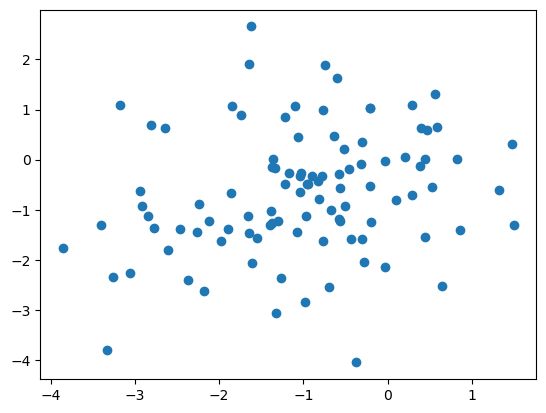

In [9]:
# define and use the generator model
from numpy.random import randn
from keras.models import Sequential
from keras.layers import Dense
from matplotlib import pyplot
 
# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n):
    # generate points in the latent space
    x_input = randn(latent_dim * n)
    # reshape into a batch of inputs for the network
    x_input = x_input.reshape(n, latent_dim)
    return x_input


# use the generator to generate n fake examples and plot the results
def generate_fake_samples(generator, latent_dim, n):
    # generate points in latent space
    x_input = generate_latent_points(latent_dim, n)
    # predict outputs
    X = generator.predict(x_input)
    # plot the results
    pyplot.scatter(X[:, 0], X[:, 1])
    pyplot.show()
    
    
# size of the latent space
latent_dim = 5
# define the discriminator model
model = define_generator(latent_dim)
# generate and plot generated samples
generate_fake_samples(model, latent_dim, 100)

We have now seen how to define and use the generator model. We will need to use the generator model in this way to create samples for the discriminator to classify.

We have not seen how the generator model is trained; that is next.

## Training the Generator Model

The weights in the generator model are updated based on the performance of the discriminator model.

When the discriminator is good at detecting fake samples, the generator is updated more, and when the discriminator model is relatively poor or confused when detecting fake samples, the generator model is updated less.

This defines the **zero-sum** or adversarial relationship between these two models.

There may be many ways to implement this using the Keras API, but perhaps the simplest approach is to create a new model that subsumes or encapsulates the generator and discriminator models.

Specifically, a new GAN model can be defined that stacks the generator and discriminator such that the generator receives as input random points in the latent space, generates samples that are fed into the discriminator model directly, classified, and the output of this larger model can be used to update the model weights of the generator.

To be clear, we are not talking about a new third model, just a logical third model that uses the already-defined layers and weights from the standalone generator and discriminator models.

Only the discriminator is concerned with distinguishing between real and fake examples; therefore, the discriminator model can be trained in a standalone manner on examples of each.

The generator model is only concerned with the discriminator’s performance on fake examples. Therefore, we will mark all of the layers in the discriminator as not trainable when it is part of the GAN model so that they can not be updated and overtrained on fake examples.

When training the generator via this subsumed GAN model, there is one more important change. We want the discriminator to think that the samples output by the generator are real, not fake. Therefore, when the generator is trained as part of the GAN model, we will mark the generated samples as real (class 1).

We can imagine that the discriminator will then classify the generated samples as not real (class 0) or a low probability of being real (0.3 or 0.5). The backpropagation process used to update the model weights will see this as a large error and will update the model weights (i.e. only the weights in the generator) to correct for this error, in turn making the generator better at generating plausible fake samples.

Let’s make this concrete.

- Inputs: Point in latent space, e.g. a five-element vector of Gaussian random numbers.
- Outputs: Binary classification, likelihood the sample is real (or fake).


The define_gan() function below takes as arguments the already-defined generator and discriminator models and creates the new logical third model subsuming these two models. The weights in the discriminator are marked as not trainable, which only affects the weights as seen by the GAN model and not the standalone discriminator model.

The GAN model then uses the same binary cross entropy loss function as the discriminator and the efficient Adam version of stochastic gradient descent.

In [10]:
# define the combined generator and discriminator model, for updating the generator
def define_gan(generator, discriminator):
    # make weights in the discriminator not trainable
    discriminator.trainable = False
    # connect them
    model = Sequential()
    # add generator
    model.add(generator)
    # add the discriminator
    model.add(discriminator)
    # compile model
    model.compile(loss='binary_crossentropy', optimizer='adam')
    return model

Making the discriminator not trainable is a clever trick in the Keras API.

The trainable property impacts the model when it is compiled. The discriminator model was compiled with trainable layers, therefore the model weights in those layers will be updated when the standalone model is updated via calls to train_on_batch().

The discriminator model was marked as not trainable, added to the GAN model, and compiled. In this model, the model weights of the discriminator model are not trainable and cannot be changed when the GAN model is updated via calls to train_on_batch().

This behavior is described in the Keras API documentation here:

How can I “freeze” Keras layers?
The complete example of creating the discriminator, generator, and composite model is listed below.

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_4 (Sequential)   (None, 2)                 122       
                                                                 
 sequential_3 (Sequential)   (None, 1)                 101       
                                                                 
Total params: 223
Trainable params: 122
Non-trainable params: 101
_________________________________________________________________


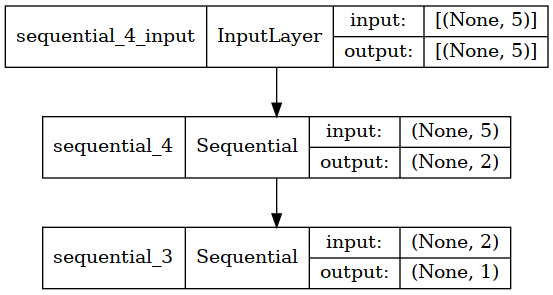

In [11]:
from keras.models import Sequential
from keras.layers import Dense
from keras.utils.vis_utils import plot_model
 
# define the standalone discriminator model
def define_discriminator(n_inputs=2):
    model = Sequential()
    model.add(Dense(25, activation='relu', kernel_initializer='he_uniform', input_dim=n_inputs))
    model.add(Dense(1, activation='sigmoid'))
    # compile model
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model
 
# define the standalone generator model
def define_generator(latent_dim, n_outputs=2):
    model = Sequential()
    model.add(Dense(15, activation='relu', kernel_initializer='he_uniform', input_dim=latent_dim))
    model.add(Dense(n_outputs, activation='linear'))
    return model
 
# define the combined generator and discriminator model, for updating the generator
def define_gan(generator, discriminator):
    # make weights in the discriminator not trainable
    discriminator.trainable = False
    # connect them
    model = Sequential()
    # add generator
    model.add(generator)
    # add the discriminator
    model.add(discriminator)
    # compile model
    model.compile(loss='binary_crossentropy', optimizer='adam')
    return model
 
# size of the latent space
latent_dim = 5
# create the discriminator
discriminator = define_discriminator()
# create the generator
generator = define_generator(latent_dim)
# create the gan
gan_model = define_gan(generator, discriminator)
# summarize gan model
gan_model.summary()
# plot gan model
plot_model(gan_model, to_file='gan_plot.png', show_shapes=True, show_layer_names=True)

Training the composite model involves generating a batch-worth of points in the latent space via the generate_latent_points() function in the previous section, and class=1 labels and calling the train_on_batch() function.

The train_gan() function below demonstrates this, although it is pretty uninteresting as only the generator will be updated each epoch, leaving the discriminator with default model weights.

In [12]:
# train the composite model
def train_gan(gan_model, latent_dim, n_epochs=10000, n_batch=128):
    # manually enumerate epochs
    for i in range(n_epochs):
        # prepare points in latent space as input for the generator
        x_gan = generate_latent_points(latent_dim, n_batch)
        # create inverted labels for the fake samples
        y_gan = ones((n_batch, 1))
        # update the generator via the discriminator's error
        gan_model.train_on_batch(x_gan, y_gan)

Instead, what is required is that we first update the discriminator model with real and fake samples, then update the generator via the composite model.

This requires combining elements from the train_discriminator() function defined in the discriminator section and the train_gan() function defined above. It also requires that the generate_fake_samples() function use the generator model to generate fake samples instead of generating random numbers.

The complete train function for updating the discriminator model and the generator (via the composite model) is listed below.

In [13]:
# train the generator and discriminator
def train(g_model, d_model, gan_model, latent_dim, n_epochs=10000, n_batch=128):
    # determine half the size of one batch, for updating the discriminator
    half_batch = int(n_batch / 2)
    # manually enumerate epochs
    for i in range(n_epochs):
        # prepare real samples
        x_real, y_real = generate_real_samples(half_batch)
        # prepare fake examples
        x_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
        # update discriminator
        d_model.train_on_batch(x_real, y_real)
        d_model.train_on_batch(x_fake, y_fake)
        # prepare points in latent space as input for the generator
        x_gan = generate_latent_points(latent_dim, n_batch)
        # create inverted labels for the fake samples
        y_gan = ones((n_batch, 1))
        # update the generator via the discriminator's error
        gan_model.train_on_batch(x_gan, y_gan)

## Evaluating the Performance of the GAN

Generally, there are no objective ways to evaluate the performance of a GAN model.

In this specific case, we can devise an objective measure for the generated samples as we know the true underlying input domain and target function and can calculate an objective error measure.

Nevertheless, we will not calculate this objective error score in this tutorial. Instead, we will use the subjective approach used in most GAN applications. Specifically, we will use the generator to generate new samples and inspect them relative to real samples from the domain.

First, we can use the generate_real_samples() function developed in the discriminator part above to generate real examples. Creating a scatter plot of these examples will create the familiar u-shape of our target function.

In [14]:
# generate n real samples with class labels
def generate_real_samples(n):
    # generate inputs in [-0.5, 0.5]
    X1 = rand(n) - 0.5
    # generate outputs X^2
    X2 = X1 * X1
    # stack arrays
    X1 = X1.reshape(n, 1)
    X2 = X2.reshape(n, 1)
    X = hstack((X1, X2))
    # generate class labels
    y = ones((n, 1))
    return X, y

Next, we can use the generator model to generate the same number of fake samples.

This requires first generating the same number of points in the latent space via the generate_latent_points() function developed in the generator section above. These can then be passed to the generator model and used to generate samples that can also be plotted on the same scatter plot.

In [15]:
# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n):
    # generate points in the latent space
    x_input = randn(latent_dim * n)
    # reshape into a batch of inputs for the network
    x_input = x_input.reshape(n, latent_dim)
    return x_input

The generate_fake_samples() function below generates these fake samples and the associated class label of 0 which will be useful later.

In [16]:
def generate_fake_samples(generator, latent_dim, n):
    # generate points in latent space
    x_input = generate_latent_points(latent_dim, n)
    # predict outputs
    X = generator.predict(x_input)
    # create class labels
    y = zeros((n, 1))
    return X, y

Having both samples plotted on the same graph allows them to be directly compared to see if the same input and output domain are covered and whether the expected shape of the target function has been appropriately captured, at least subjectively.

The summarize_performance() function below can be called any time during training to create a scatter plot of real and generated points to get an idea of the current capability of the generator model.

In [17]:
# plot real and fake points
def summarize_performance(generator, latent_dim, n=100):
 # prepare real samples
 x_real, y_real = generate_real_samples(n)
 # prepare fake examples
 x_fake, y_fake = generate_fake_samples(generator, latent_dim, n)
 # scatter plot real and fake data points
 pyplot.scatter(x_real[:, 0], x_real[:, 1], color='red')
 pyplot.scatter(x_fake[:, 0], x_fake[:, 1], color='blue')
 pyplot.show()

We may also be interested in the performance of the discriminator model at the same time.

Specifically, we are interested to know how well the discriminator model can correctly identify real and fake samples. A good generator model should make the discriminator model confused, resulting in a classification accuracy closer to 50% on real and fake examples.

We can update the summarize_performance() function to also take the discriminator and current epoch number as arguments and report the accuracy on the sample of real and fake example

In [18]:
# evaluate the discriminator and plot real and fake points
def summarize_performance(epoch, generator, discriminator, latent_dim, n=100):
    # prepare real samples
    x_real, y_real = generate_real_samples(n)
    # evaluate discriminator on real examples
    _, acc_real = discriminator.evaluate(x_real, y_real, verbose=0)
    # prepare fake examples
    x_fake, y_fake = generate_fake_samples(generator, latent_dim, n)
    # evaluate discriminator on fake examples
    _, acc_fake = discriminator.evaluate(x_fake, y_fake, verbose=0)
    # summarize discriminator performance
    print(epoch, acc_real, acc_fake)
    # scatter plot real and fake data points
    pyplot.scatter(x_real[:, 0], x_real[:, 1], color='red')
    pyplot.scatter(x_fake[:, 0], x_fake[:, 1], color='blue')
    pyplot.show()

This function can then be called periodically during training.

For example, if we choose to train the models for 10,000 iterations, it may be interesting to check-in on the performance of the model every 2,000 iterations.

We can achieve this by parameterizing the frequency of the check-in via n_eval argument, and calling the summarize_performance() function from the train() function after the appropriate number of iterations.

The updated version of the train() function with this change is listed below.

In [19]:
# train the generator and discriminator
def train(g_model, d_model, gan_model, latent_dim, n_epochs=10000, n_batch=128, n_eval=2000):
    # determine half the size of one batch, for updating the discriminator
    half_batch = int(n_batch / 2)
    # manually enumerate epochs
    for i in range(n_epochs):
        # prepare real samples
        x_real, y_real = generate_real_samples(half_batch)
        # prepare fake examples
        x_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
        # update discriminator
        d_model.train_on_batch(x_real, y_real)
        d_model.train_on_batch(x_fake, y_fake)
        # prepare points in latent space as input for the generator
        x_gan = generate_latent_points(latent_dim, n_batch)
        # create inverted labels for the fake samples
        y_gan = ones((n_batch, 1))
        # update the generator via the discriminator's error
        gan_model.train_on_batch(x_gan, y_gan)
        # evaluate the model every n_eval epochs
        if (i+1) % n_eval == 0:
            summarize_performance(i, g_model, d_model, latent_dim)

##  Complete Example of Training the GAN

We now have everything we need to train and evaluate a GAN on our chosen one-dimensional function.

The complete example is listed below.

399 0.8999999761581421 0.27000001072883606


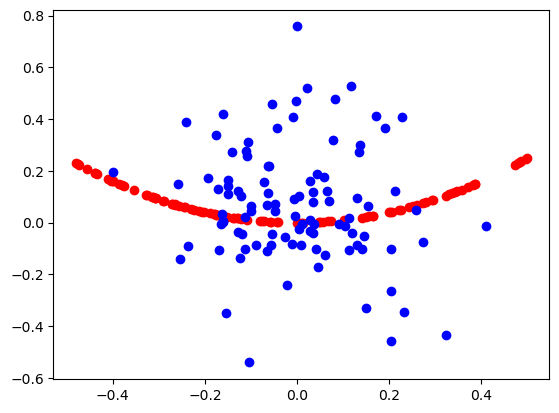

799 0.800000011920929 0.2199999988079071


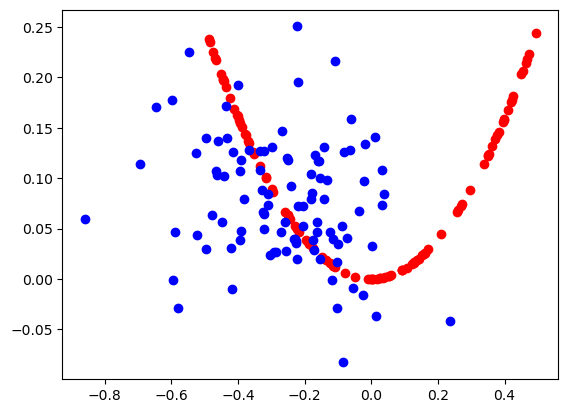

1199 0.7900000214576721 0.1599999964237213


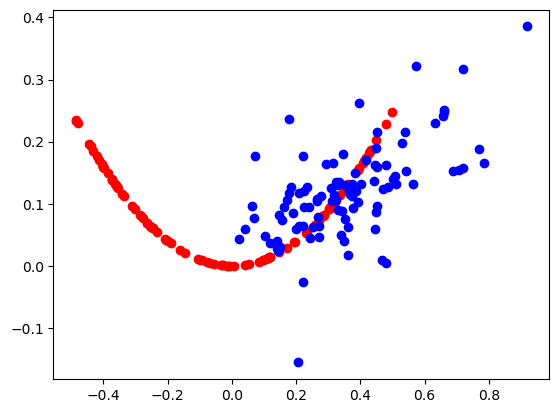

1599 0.5 1.0


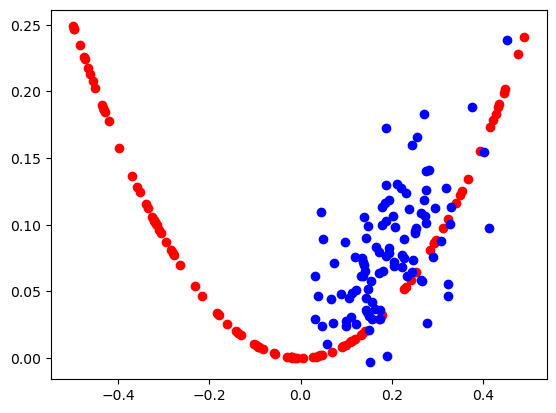

1999 0.5199999809265137 1.0


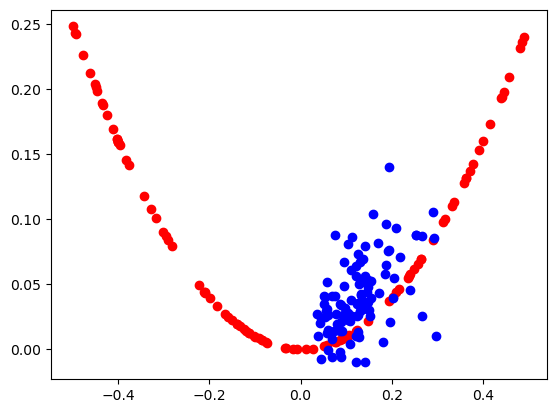

2399 0.4399999976158142 1.0


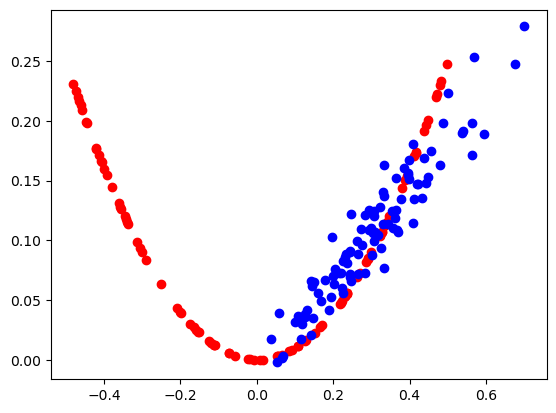

2799 0.38999998569488525 0.07000000029802322


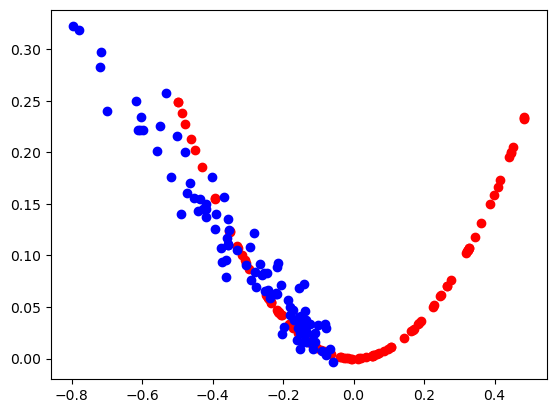

3199 0.3199999928474426 1.0


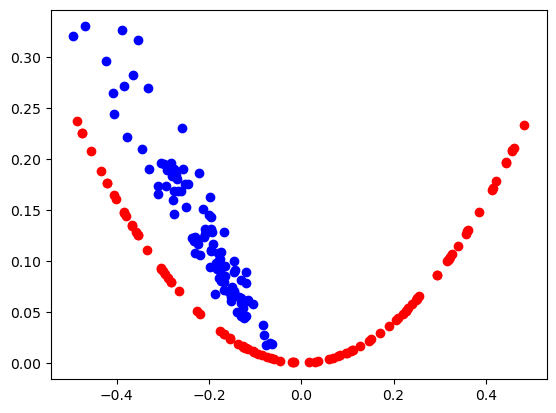

3599 0.44999998807907104 1.0


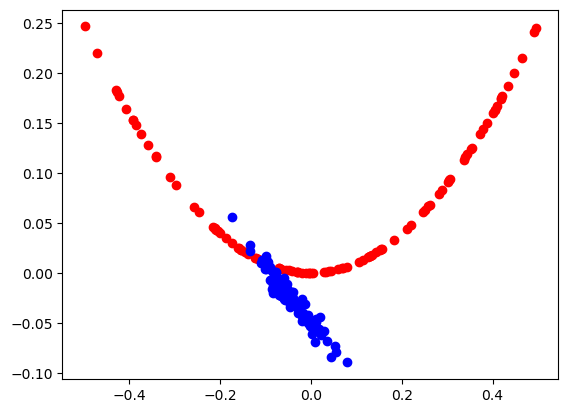

3999 0.4000000059604645 1.0


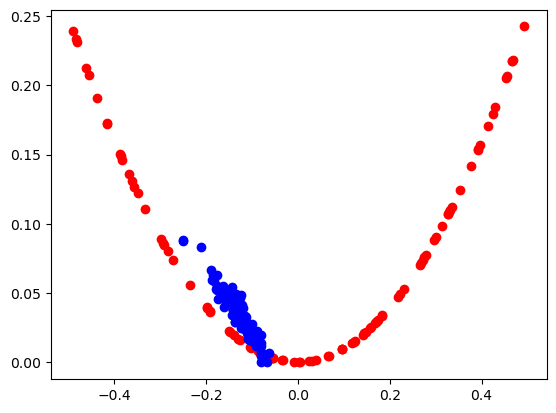

4399 0.41999998688697815 1.0


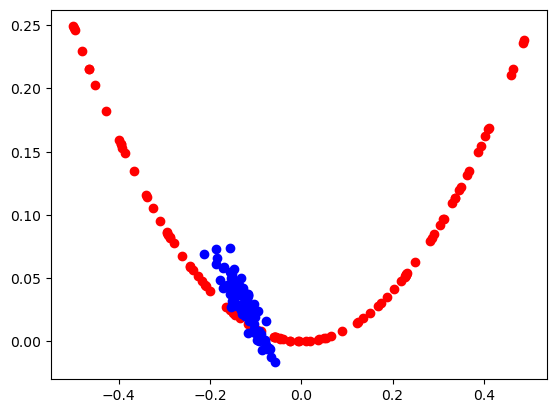

4799 0.30000001192092896 1.0


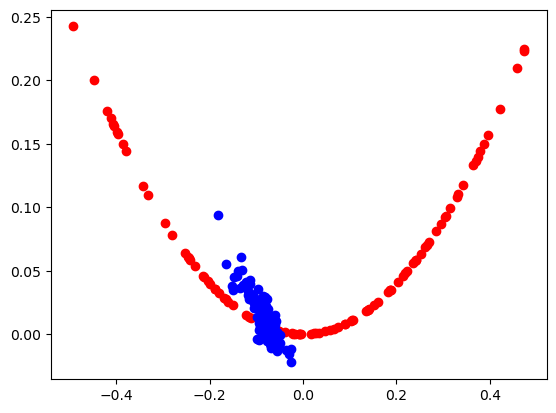

5199 0.550000011920929 1.0


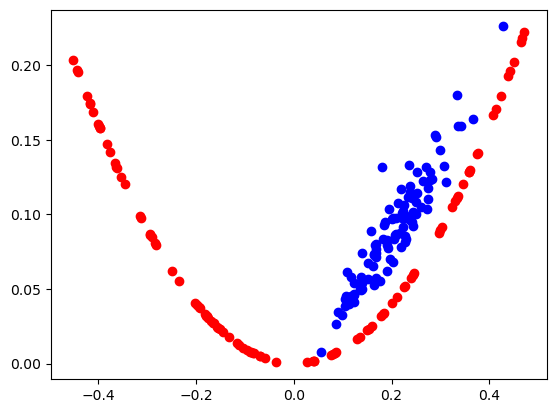

5599 0.38999998569488525 0.009999999776482582


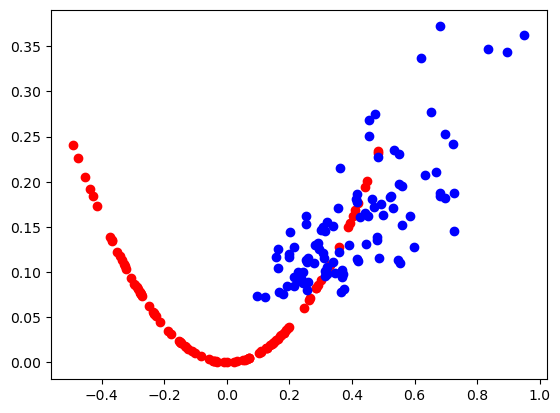

5999 0.46000000834465027 1.0


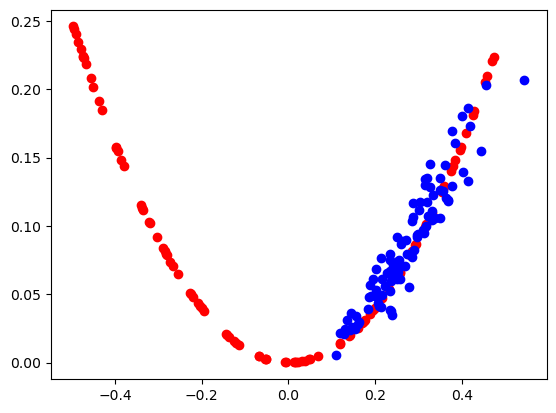

6399 0.46000000834465027 0.8199999928474426


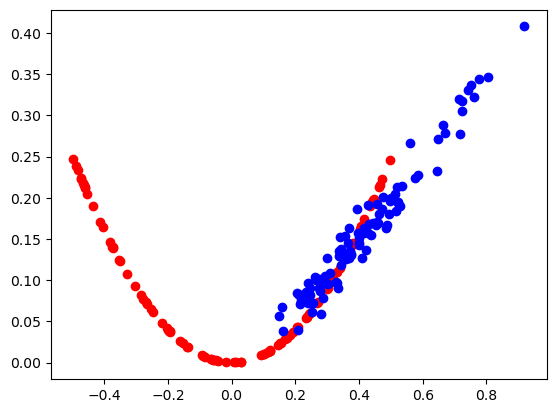

6799 0.27000001072883606 1.0


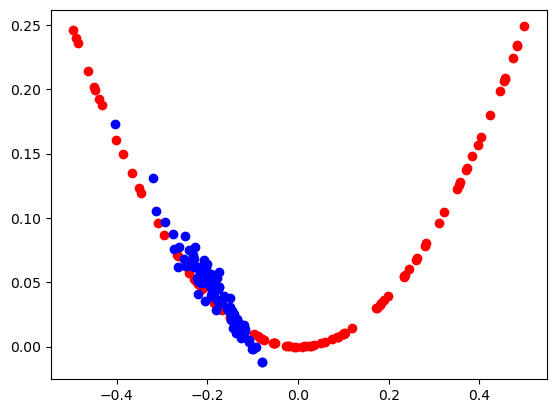

7199 0.49000000953674316 0.009999999776482582


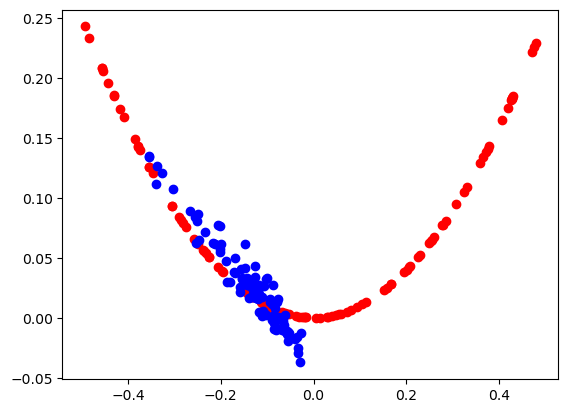

7599 0.5400000214576721 1.0


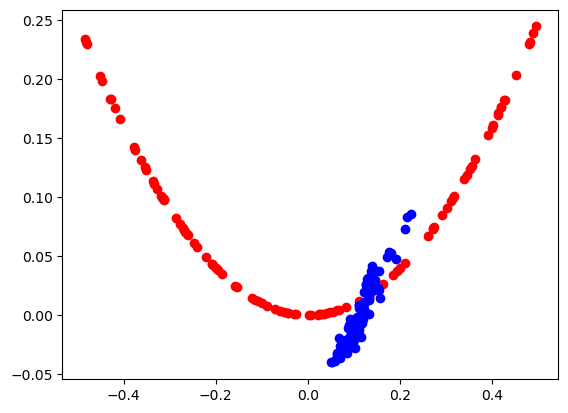

7999 0.3400000035762787 1.0


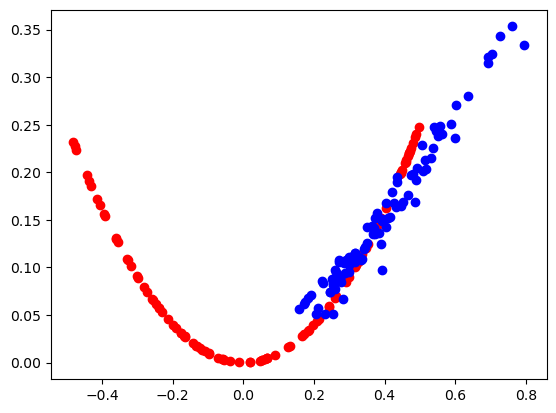

8399 0.41999998688697815 1.0


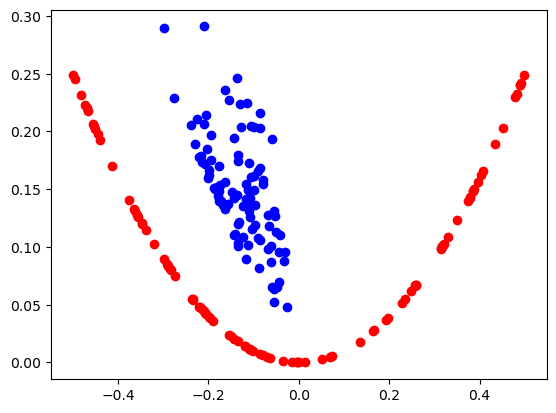

8799 0.44999998807907104 1.0


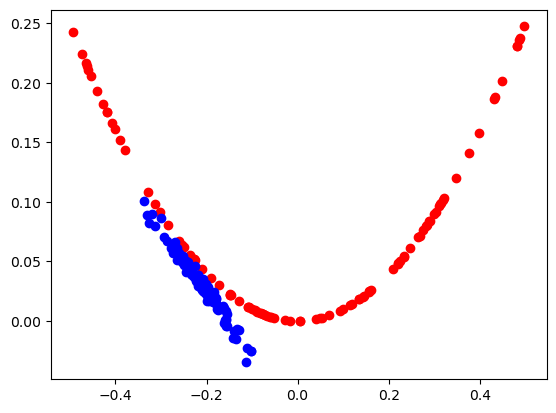

9199 0.4699999988079071 0.5199999809265137


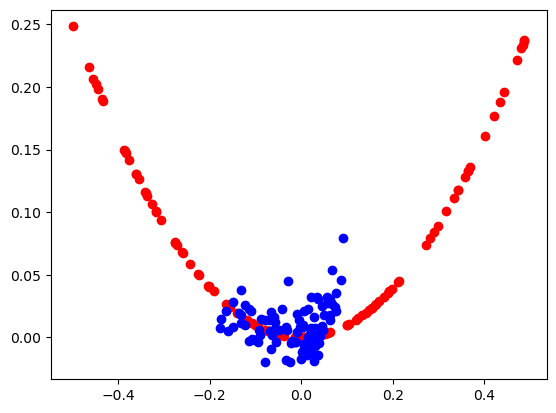

9599 0.5899999737739563 0.0


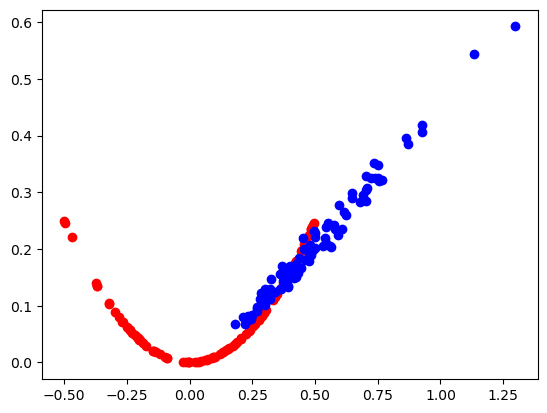

9999 0.4699999988079071 1.0


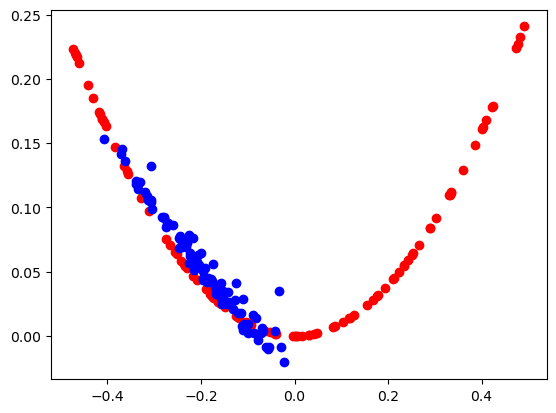

In [20]:
# train a generative adversarial network on a one-dimensional function
from numpy import hstack
from numpy import zeros
from numpy import ones
from numpy.random import rand
from numpy.random import randn
from keras.models import Sequential
from keras.layers import Dense
from matplotlib import pyplot
 
# define the standalone discriminator model
def define_discriminator(n_inputs=2):
    model = Sequential()
    model.add(Dense(25, activation='relu', kernel_initializer='he_uniform', input_dim=n_inputs))
    model.add(Dense(1, activation='sigmoid'))
    # compile model
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model
 
# define the standalone generator model
def define_generator(latent_dim, n_outputs=2):
    model = Sequential()
    model.add(Dense(15, activation='relu', kernel_initializer='he_uniform', input_dim=latent_dim))
    model.add(Dense(n_outputs, activation='linear'))
    return model
 
# define the combined generator and discriminator model, for updating the generator
def define_gan(generator, discriminator):
    # make weights in the discriminator not trainable
    discriminator.trainable = False
    # connect them
    model = Sequential()
    # add generator
    model.add(generator)
    # add the discriminator
    model.add(discriminator)
    # compile model
    model.compile(loss='binary_crossentropy', optimizer='adam')
    return model
 
# generate n real samples with class labels
def generate_real_samples(n):
    # generate inputs in [-0.5, 0.5]
    X1 = rand(n) - 0.5
    # generate outputs X^2
    X2 = X1 * X1
    # stack arrays
    X1 = X1.reshape(n, 1)
    X2 = X2.reshape(n, 1)
    X = hstack((X1, X2))
    # generate class labels
    y = ones((n, 1))
    return X, y
 
# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n):
    # generate points in the latent space
    x_input = randn(latent_dim * n)
    # reshape into a batch of inputs for the network
    x_input = x_input.reshape(n, latent_dim)
    return x_input
 
# use the generator to generate n fake examples, with class labels
def generate_fake_samples(generator, latent_dim, n):
    # generate points in latent space
    x_input = generate_latent_points(latent_dim, n)
    # predict outputs
    X = generator.predict(x_input)
    # create class labels
    y = zeros((n, 1))
    return X, y
 
# evaluate the discriminator and plot real and fake points
def summarize_performance(epoch, generator, discriminator, latent_dim, n=100):
    # prepare real samples
    x_real, y_real = generate_real_samples(n)
    # evaluate discriminator on real examples
    _, acc_real = discriminator.evaluate(x_real, y_real, verbose=0)
    # prepare fake examples
    x_fake, y_fake = generate_fake_samples(generator, latent_dim, n)
    # evaluate discriminator on fake examples
    _, acc_fake = discriminator.evaluate(x_fake, y_fake, verbose=0)
    # summarize discriminator performance
    print(epoch, acc_real, acc_fake)
    # scatter plot real and fake data points
    pyplot.scatter(x_real[:, 0], x_real[:, 1], color='red')
    pyplot.scatter(x_fake[:, 0], x_fake[:, 1], color='blue')
    pyplot.show()

# train the generator and discriminator
def train(g_model, d_model, gan_model, latent_dim, n_epochs=10000, n_batch=128, n_eval=400):
    # determine half the size of one batch, for updating the discriminator
    half_batch = int(n_batch / 2)
    # manually enumerate epochs
    for i in range(n_epochs):
        # prepare real samples
        x_real, y_real = generate_real_samples(half_batch)
        # prepare fake examples
        x_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
        # update discriminator
        d_model.train_on_batch(x_real, y_real)
        d_model.train_on_batch(x_fake, y_fake)
        # prepare points in latent space as input for the generator
        x_gan = generate_latent_points(latent_dim, n_batch)
        # create inverted labels for the fake samples
        y_gan = ones((n_batch, 1))
        # update the generator via the discriminator's error
        gan_model.train_on_batch(x_gan, y_gan)
        # evaluate the model every n_eval epochs
        if (i+1) % n_eval == 0:
            summarize_performance(i, g_model, d_model, latent_dim)

# size of the latent space
latent_dim = 5
# create the discriminator
discriminator = define_discriminator()
# create the generator
generator = define_generator(latent_dim)
# create the gan
gan_model = define_gan(generator, discriminator)
# train model
train(generator, discriminator, gan_model, latent_dim)
